# Homework 1
## Jesse Ellin
## Logistic Regression

### Task 1 : Problem to Solve
I will be predicting the probability of a sonar reading being a mine or a rock. This dataset is particularly relevant to me as I have recently gotten into mountaineering as a hobby. In the very recent past, a climber was lost in the Sierra mountains. After weeks of search, it is believed he fell into a deep ravine that was previously unregistered. However, drone footage suggested the ravine may not have been as deep as reported. For the purposes of search-and-rescue operations, it isn't enough to simply say "yes" or "no" to what a sonar reading is, you also need the probability of it being an accurate reading to properly allocate resources.

### Task 2 : Data Source
The data was pulled from https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

The data set contains signals obtained from a variety of different angles, spanning 90 degrees for the cylinder and 180 degrees for the rock. Each pattern consists of a set of 60 numbers ranged 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time. The label associated with each record is mapped {"M" : "Mine", "R" : "Rock"}.

The data has the following structure:

| Reading | Label |
| ------- | ----- |
| List of 60 float readings in range (0,1) | "R" for Rock, "M" for Mine label |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from time import time

Due to how the data is originally stored, we need to transcribe the data into a usable format

In [2]:
with open("sonar.all-data") as f:
    data = f.read().strip().split('\n')
    readings = [[float(line.split(',')[i]) for line in data] for i in range(60)]
    labels = [line.split(',')[-1] for line in data]

In [3]:
import pandas as pd
data_dict = {f"R{i+1}" : readings[i] for i in range(60)}
data_dict["Label"] = labels
df = pd.DataFrame(data_dict)

We now look at some basic data exploration

In [4]:
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R52,R53,R54,R55,R56,R57,R58,R59,R60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
df.shape

(208, 61)

In [6]:
df.isna().sum()

R1       0
R2       0
R3       0
R4       0
R5       0
        ..
R57      0
R58      0
R59      0
R60      0
Label    0
Length: 61, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R1      208 non-null    float64
 1   R2      208 non-null    float64
 2   R3      208 non-null    float64
 3   R4      208 non-null    float64
 4   R5      208 non-null    float64
 5   R6      208 non-null    float64
 6   R7      208 non-null    float64
 7   R8      208 non-null    float64
 8   R9      208 non-null    float64
 9   R10     208 non-null    float64
 10  R11     208 non-null    float64
 11  R12     208 non-null    float64
 12  R13     208 non-null    float64
 13  R14     208 non-null    float64
 14  R15     208 non-null    float64
 15  R16     208 non-null    float64
 16  R17     208 non-null    float64
 17  R18     208 non-null    float64
 18  R19     208 non-null    float64
 19  R20     208 non-null    float64
 20  R21     208 non-null    float64
 21  R22     208 non-null    float64
 22  R2

In [8]:
df.describe()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R51,R52,R53,R54,R55,R56,R57,R58,R59,R60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


In [9]:
df.Label.value_counts(normalize=True)

M    0.533654
R    0.466346
Name: Label, dtype: float64

We will map the Label column using {"M" : 1, "R" : 0}

In [10]:
df["Label"] = [1 if val == "M" else 0 for val in df["Label"]]

Due to the large feature space in the data, we will first apply feature grouping to reduce the feature space. For simplicity, we will simply cluster every 10 frequency bands together, reducing the feature space from 60 to 6

In [11]:
for column in df.columns:
    if "Cluster" in column:
        df = df.drop(columns=[column])
cluster_count = 6
cluster_step = 60 // cluster_count
for i in range(cluster_count):
    df[f"Cluster{i+1}"] = sum([df[f"R{j+1}"] for j in range(cluster_step*i, cluster_step*i+cluster_step)]) / cluster_count

In [12]:
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R58,R59,R60,Label,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0084,0.0090,0.0032,0,0.191767,0.416350,0.994833,0.901650,0.292550,0.018467
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0049,0.0052,0.0044,0,0.302000,1.296833,0.601233,0.420833,0.130867,0.015267
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0164,0.0095,0.0078,0,0.404567,1.158750,0.975817,0.806150,0.270000,0.026717
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0044,0.0040,0.0117,0,0.098467,0.336417,0.645533,1.057133,0.511567,0.015950
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0048,0.0107,0.0094,0,0.254017,0.775267,0.899933,0.560583,0.150817,0.013200


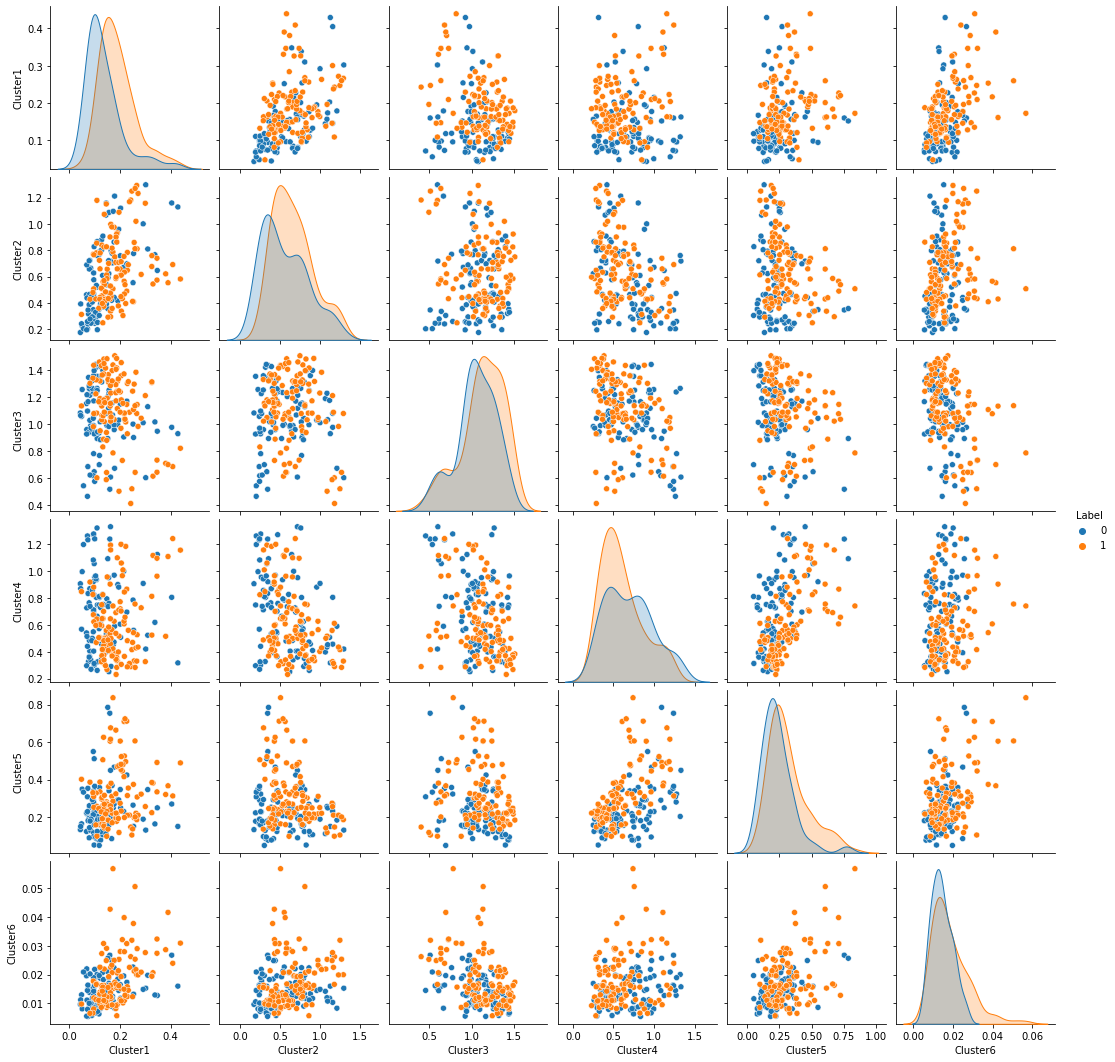

In [13]:
sns.pairplot(df.drop(columns=[f"R{i+1}" for i in range(60)]), hue="Label")

As we can see from this pairplot, there is no clear band frequency range pairing that provides clear separability in the data. It seems combinations of pairings might provide some insight, but with the model we are using, we would need to manually construct features. Instead, we will simply use the original dataset.

In [14]:
df = df.drop(columns = [col for col in df.columns if "Cluster" in col])

<AxesSubplot:>

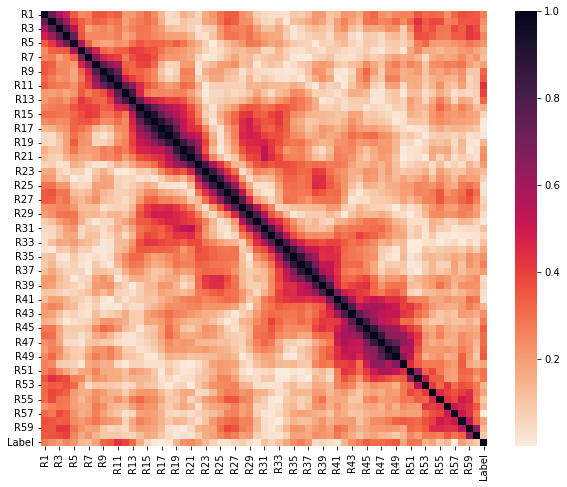

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr().abs(), annot=False, ax=ax, cmap="rocket_r")

As expected, the closer two frequency bands are to each other, the stronger their correlation. However, we also see some correlation spikes in more distant frequency bands.

### Task 3 : Logistic Regression
For this, I will be using standard SGD and mini-batch GD. While more advanced approaches like Adam may have faster results, SGD and mini-batch are known to provide strong results. (NOTE: For SGD, I set the random_state before any training was done to maintain consistency when tuning hyper-parameters)
### Task 4 : Optimization
I will use Momentum and Adam optimizations. I chose Momentum to see how a fundamental optimization technique improves performance, and I chose Adam to see how a more state-of-the-art and standard technique compares.

In [16]:
def sigmoid(a):
    return 1 / (1 + np.exp(-1 * a))
                
class LogReg:
    def __init__(self, input_shape, lr=0.01, gamma=0.9, b1=0.9, b2=0.999, epsilon=1e-8):
        self.W = np.random.uniform(size=input_shape)
        self.b = np.random.uniform(0, 1)
        self.lr = lr
        self.gamma = gamma
        self.vw = 0
        self.vb = 0
        self.b1 = b1
        self.b2 = b2
        self.epsilon = epsilon
        self.mw = np.zeros(shape=X.shape[1])
        self.mb = 0
        self.t = 0
    
    def train(self, X, Y, epochs=10, update="sgd", batch=1, optimizer=None, early_stopping=False, val=None, patience=1):
        local_patience = 0
        if early_stopping:
            prior_loss = self.loss(self.predict(val[0]), val[1])
        for i in tqdm(range(epochs)):
            self.t += 1
            if update == "sgd":
                X, Y = shuffle(X, Y, random_state=42)
                for x, y in zip(X, Y):
                    self.step(self.gradient(np.array([x]),np.array([y])), optimizer)
            
            elif update == "mini":
                X, Y = shuffle(X, Y)
                self.step(self.gradient(X[:batch], Y[:batch]), optimizer)
            
            if early_stopping:
                loss = self.loss(self.predict(val[0]), val[1])
                if loss - prior_loss <= early_stopping:
                    local_patience += 1
                    if local_patience == patience:
                        return
                else:
                    local_patience = 0
                prior_loss = loss

    def predict(self, X):
        try:
            return sigmoid(X @ self.W + self.b)
        except:
            print(X)
            print(X.shape, self.W.shape, self.b.shape)
    
    def loss(self, Y_pred, Y):
        return -1/len(Y_pred) * (((-Y).T @ np.log(Y_pred)) - ((1 - Y).T @ np.log(1 - Y_pred)))

    def gradient(self, X, Y):
        n = X.shape[0]
        Y_pred = self.predict(X)
        return {"W" : (Y_pred-Y) @ X/n, "B" : np.sum(Y_pred - Y)/n}
    
    def step(self, grads, optimizer):
        if optimizer == None:
            self.W = self.W - self.lr * grads["W"]
            self.b = self.b - self.lr * grads["B"]
        elif optimizer == "momentum":
            self.vw = self.gamma * self.vw + self.lr * grads["W"]
            self.vb = self.gamma * self.vb + self.lr * grads["B"]
            self.W = self.W - self.vw
            self.b = self.b - self.vb
        elif optimizer == "adam":
            self.mw = (self.b1 * self.mw + (1 - self.b1) * grads["W"])
            self.mb = (self.b1 * self.mb + (1 - self.b1) * grads["B"])
            self.vw = (self.b2 * self.vw + (1 - self.b2) * grads["W"]**2)
            self.vb = (self.b2 * self.vb + (1 - self.b2) * grads["B"]**2)
            mw_corr = self.mw / (1 - self.b1**self.t)
            vw_corr = self.vw / (1 - self.b1**self.t)
            mb_corr = self.mb / (1 - self.b2**self.t)
            vb_corr = self.vb / (1 - self.b2**self.t)
            self.W = self.W - self.lr * (mw_corr) / (np.sqrt(vw_corr) + self.epsilon)
            self.b = self.b - self.lr * (mb_corr) / (np.sqrt(vb_corr) + self.epsilon)

In [17]:
X = df.drop(columns=["Label"]).to_numpy()
Y = df["Label"].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [18]:
transformer = Normalizer(norm="max").fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [19]:
sgd_epochs = 10000
mini_epochs = 10000
batch_size = X.shape[0] // 100
early_stop = 1e-6
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
X_val = transformer.transform(X_val)
patience = 5

#### Part 3 training
The following cells train SGD LogReg and mini LogReg without optimization

In [20]:
SGD_LR = LogReg(X_train.shape[1])

In [21]:
start = time()
SGD_LR.train(X_train, Y_train, epochs=sgd_epochs, update="sgd", early_stopping=early_stop, val=(X_val,Y_val), patience=patience)
end = time()
SGD_time = end - start

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
mini_LR = LogReg(X_train.shape[1])

In [23]:
start = time()
mini_LR.train(X_train, Y_train, epochs=mini_epochs, update="mini", batch=batch_size, early_stopping=early_stop, val=(X_val,Y_val), patience=patience)
end = time()
mini_time = end - start

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Part 4 training
The following cells train SGD LogReg and mini LogReg with optimization

In [24]:
SGD_momentum_LR = LogReg(X_train.shape[1])
SGD_adam_LR = LogReg(X_train.shape[1])
mini_momentum_LR = LogReg(X_train.shape[1])
mini_adam_LR = LogReg(X_train.shape[1])

In [25]:
start = time()
SGD_momentum_LR.train(X_train, Y_train, epochs=sgd_epochs, update="sgd", optimizer="momentum", early_stopping=early_stop, val=(X_val,Y_val), patience=patience)
end = time()
SGD_momentum_time = end - start

  0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
start = time()
SGD_adam_LR.train(X_train, Y_train, epochs=sgd_epochs, update="sgd", optimizer="adam", early_stopping=early_stop, val=(X_val,Y_val), patience=patience)
end = time()
SGD_adam_time = end - start

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
start = time()
mini_momentum_LR.train(X_train, Y_train, epochs=mini_epochs, batch=batch_size, update="mini", optimizer="momentum", early_stopping=early_stop, val=(X_val,Y_val), patience=patience)
end = time()
mini_momentum_time = end - start

  0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
start = time()
mini_adam_LR.train(X_train, Y_train, epochs=mini_epochs, batch=batch_size, update="mini", optimizer="adam", early_stopping=early_stop, val=(X_val,Y_val), patience=patience)
end = time()
mini_adam_time = end - start

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Model Performance
We will now construct a model performance analysis table. For F1-score, we will set an arbitrary threshold at 0.5. The table will have the following structure:

| Descent Approach | Optimizer | Training Time | Epochs | Train Accuracy | Train F1-score | Test Accuracy | Test F1-score |
| ---------------- | --------- | ------------- | ------ | -------------- | -------------- | ------------- | ------------- |

In [29]:
def accuracy(model, X, Y, skip=False, threshold=0.5):
    if skip:
        return accuracy_score(Y==1, model.predict(X)>=threshold)
    return np.sum(np.equal((model.predict(X) >= threshold), (Y==1))) / X.shape[0]

def f1(model, X, Y, threshold=0.5, skip=False):
    pred = model.predict(X)
    pred = (pred >= threshold)
    Y_bool = (Y == 1)
    if skip:
        return f1_score(Y_bool, pred)
    
    tp = np.sum(pred & Y_bool)
    fp = np.sum(pred & Y_bool == False)
    fn = np.sum(pred == False & Y_bool)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(precision, recall)
    return 2 * (precision * recall) / (precision + recall)

In [30]:
descents = ["SGD", "SGD", "SGD", "Mini-batch", "Mini-batch", "Mini-batch"]
optimizers = ["None", "Momentum", "Adam", "None", "Momentum", "Adam"]
train_accuracies = [accuracy(model, X_train, Y_train, skip=True) for model in [SGD_LR, SGD_momentum_LR, SGD_adam_LR, mini_LR, mini_momentum_LR, mini_adam_LR]]
train_f1s = [f1(model, X_train, Y_train, skip=True) for model in [SGD_LR, SGD_momentum_LR, SGD_adam_LR, mini_LR, mini_momentum_LR, mini_adam_LR]]
test_accuracies = [accuracy(model, X_test, Y_test, skip=True) for model in [SGD_LR, SGD_momentum_LR, SGD_adam_LR, mini_LR, mini_momentum_LR, mini_adam_LR]]
test_f1s = [f1(model, X_test, Y_test, skip=True) for model in [SGD_LR, SGD_momentum_LR, SGD_adam_LR, mini_LR, mini_momentum_LR, mini_adam_LR]]

In [31]:
results = pd.DataFrame({
    "Descent Approach" : descents,
    "Optimizer" : optimizers,
    "Training Time" : [SGD_time, SGD_momentum_time, SGD_adam_time, mini_time, mini_momentum_time, mini_adam_time],
    "Epochs" : [model.t for model in [SGD_LR, SGD_momentum_LR, SGD_adam_LR, mini_LR, mini_momentum_LR, mini_adam_LR]],
    "Train Accuracy" : train_accuracies,
    "Train F1-score" : train_f1s,
    "Test Accuracy" : test_accuracies,
    "Test F1-score" : test_f1s,
})

In [32]:
results

,Descent Approach,Optimizer,Training Time,Epochs,Train Accuracy,Train F1-score,Test Accuracy,Test F1-score
0,SGD,None,2.086998,607,0.823529,0.843602,0.833333,0.872727
1,SGD,Momentum,4.672034,1274,0.893048,0.898990,0.833333,0.867925
2,SGD,Adam,4.025553,727,0.909091,0.917874,0.928571,0.945455
3,Mini-batch,None,0.016997,38,0.524064,0.687719,0.619048,0.764706
4,Mini-batch,Momentum,0.017002,29,0.518717,0.328358,0.500000,0.432432
5,Mini-batch,Adam,0.015001,8,0.475936,0.000000,0.380952,0.000000


#### Part 4 Analysis
For this particular task, we have the best results with traditional SGD with Adam optimization (however, it is important to note that hyper-parameters play an important role in this). While Mini-batch converges much faster, it converges on a poorer-performing state. For this task, it seems specific optimization methods are beneficial, however others may be detrimental. Momentum seems to not converge quickly with the set hyper-parameters, thus taking the longest to train. While Adam takes more time to calculate, it converges with lower loss under these hyper-parameters with much better accuracy and f1-score. We also see that optimization is heavily dependent on descent approach, as Adam on mini-batch has by far the worst performance.